In [7]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import files
uploaded = files.upload()  # Upload `features.bin` and `labels.bin`

Saving features_v2.bin to features_v2.bin
Saving labels_v2.bin to labels_v2.bin


In [3]:
!pip install brevitas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.6/706.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
# Reload clean data from disk
import numpy as np
import struct

with open("features_v2.bin", "rb") as f:
    num_sequences = struct.unpack("Q", f.read(8))[0]
    vector_size = struct.unpack("Q", f.read(8))[0]
    features = np.frombuffer(f.read(), dtype=np.float64).reshape((num_sequences, vector_size))

with open("labels_v2.bin", "rb") as f:
    num_labels = struct.unpack("Q", f.read(8))[0]
    labels = np.frombuffer(f.read(), dtype=np.int32)

print("Feature shape:", features.shape)
print("Label distribution:", np.bincount(labels))

Feature shape: (60620, 320)
Label distribution: [  382   936 59302]


In [9]:
# Summary info (you already have this)
print("Feature shape:", features.shape)
print("Labels shape:", labels.shape)
print("Label distribution:", np.bincount(labels))
print("Any NaNs?", np.isnan(features).any())
print("Any Infs?", np.isinf(features).any())
print("Max value:", np.max(features))
print("Min value:", np.min(features))

# Peek into a few feature vectors by class
num_samples_to_print = 3

for label in [0, 1, 2]:  # 0=Up, 1=Down, 2=No Change
    print(f"\n--- Sample features for class {label} ---")
    count = 0
    for i in range(len(labels)):
        if labels[i] == label:
            print(f"Sample #{i} (label={label}):")
            print(features[i][:10], "...")  # print first 10 features only
            count += 1
            if count >= num_samples_to_print:
                break


Feature shape: (60620, 320)
Labels shape: (60620,)
Label distribution: [  382   936 59302]
Any NaNs? True
Any Infs? True
Max value: nan
Min value: nan

--- Sample features for class 0 ---
Sample #5 (label=0):
[0.00000000e+00 1.00000000e-01 1.00000000e-03 4.52077127e-02
 1.00002260e+02 2.26038564e-05 5.00000000e-04 1.00000000e-03
 1.50000000e-03 0.00000000e+00] ...
Sample #6 (label=0):
[0.00000000e+00 1.00000000e-01 1.00000000e-03 4.52077127e-02
 1.00002260e+02 2.26038564e-05 5.00000000e-04 1.00000000e-03
 1.50000000e-03 2.00000000e-03] ...
Sample #7 (label=0):
[0.00000000e+00 1.00000000e-01 1.00000000e-03 4.52077127e-02
 1.00002260e+02 2.26038564e-05 5.00000000e-04 1.00000000e-03
 1.50000000e-03 2.00000000e-03] ...

--- Sample features for class 1 ---
Sample #26 (label=1):
[0.00000000e+00 9.70000000e-02 9.69985450e-04 6.96646162e-02
 1.00004879e+02 3.37868320e-05 4.84992725e-04 5.14992275e-04
 9.84985225e-04 1.01498478e-03] ...
Sample #27 (label=1):
[0.00000000e+00 9.70000000e-02 9.699

In [10]:
# Replace inf with large finite numbers
features = np.where(np.isinf(features), np.sign(features) * 1e6, features)

# Replace NaN with 0 (or mean if preferred)
features = np.nan_to_num(features, nan=0.0)

In [11]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)


In [13]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

sequence_length = 10  # if you used that
feature_dim = X_train.shape[1] // sequence_length

# Reshape to (batch, seq, features)
X_train_t = X_train_t.view(-1, sequence_length, feature_dim)
X_test_t = X_test_t.view(-1, sequence_length, feature_dim)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from brevitas.nn import QuantLSTM, QuantLinear
from brevitas.quant import Int8ActPerTensorFixedPoint, Int8WeightPerTensorFixedPoint

class QuantLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(QuantLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = QuantLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            weight_quant=Int8WeightPerTensorFixedPoint,
            io_quant=Int8ActPerTensorFixedPoint
        )
        self.fc = QuantLinear(
            in_features=hidden_size,
            out_features=num_classes,
            bias=True,
            weight_quant=Int8WeightPerTensorFixedPoint,
            act_quant=Int8ActPerTensorFixedPoint
        )

    def forward(self, x):
        out, _ = self.lstm(x)  # Brevitas LSTM handles hidden state internally
        out = self.fc(out[:, -1, :])  # Grab output at last timestep
        return out

model = QuantLSTMModel(input_size=feature_dim, hidden_size=64, num_classes=3).to(device)

# Define class weights manually based on inverse class frequency
# [Up, Down, No Change] = [2425, 10, 57839]
class_counts = torch.tensor([884, 412, 59423], dtype=torch.float32)
inv_freqs = 1.0 / class_counts
weights = inv_freqs / inv_freqs.sum()  # Normalize
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [15]:
from sklearn.utils import resample

X_up = features[labels == 0]
y_up = labels[labels == 0]

X_down = features[labels == 1]
y_down = labels[labels == 1]

X_nc = features[labels == 2]
y_nc = labels[labels == 2]

X_up_os, y_up_os = resample(X_up, y_up, replace=True, n_samples=3000)
X_down_os, y_down_os = resample(X_down, y_down, replace=True, n_samples=3000)
X_nc_ds, y_nc_ds = resample(X_nc, y_nc, replace=False, n_samples=3000)

# Combine and shuffle
X_balanced = np.vstack([X_up_os, X_down_os, X_nc_ds])
y_balanced = np.concatenate([y_up_os, y_down_os, y_nc_ds])


In [16]:
from sklearn.metrics import f1_score

best_f1 = 0
num_epochs = 15  # or higher

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

    # Eval
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)

            all_preds.append(outputs.cpu())     # Append raw logits
            all_labels.append(yb.cpu())         # Append true labels

    all_preds = torch.cat(all_preds).argmax(dim=1).numpy()
    all_labels = torch.cat(all_labels).numpy()
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Epoch {epoch+1}, F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")


/usr/local/lib/python3.11/dist-packages/torch/_tensor.py:1624: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1935.)
  return super().rename(names)
/usr/local/lib/python3.11/dist-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:316.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1, Loss: 0.8906
Epoch 1, F1: 0.2986
Epoch 2, Loss: 0.7862
Epoch 2, F1: 0.3168
Epoch 3, Loss: 0.7070
Epoch 3, F1: 0.3661
Epoch 4, Loss: 0.6602
Epoch 4, F1: 0.3609
Epoch 5, Loss: 0.6121
Epoch 5, F1: 0.3536
Epoch 6, Loss: 0.5859
Epoch 6, F1: 0.3341
Epoch 7, Loss: 0.5611
Epoch 7, F1: 0.3857
Epoch 8, Loss: 0.5179
Epoch 8, F1: 0.3766
Epoch 9, Loss: 0.5243
Epoch 9, F1: 0.3504
Epoch 10, Loss: 0.5050
Epoch 10, F1: 0.3558
Epoch 11, Loss: 0.4913
Epoch 11, F1: 0.3372
Epoch 12, Loss: 0.4646
Epoch 12, F1: 0.4100
Epoch 13, Loss: 0.4858
Epoch 13, F1: 0.3889
Epoch 14, Loss: 0.4466
Epoch 14, F1: 0.3542
Epoch 15, Loss: 0.4561
Epoch 15, F1: 0.3919


In [17]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=["Up", "Down", "No Change"], zero_division=0))

              precision    recall  f1-score   support

          Up       0.11      0.66      0.19        76
        Down       0.06      0.86      0.12       187
   No Change       1.00      0.77      0.87     11861

    accuracy                           0.77     12124
   macro avg       0.39      0.76      0.39     12124
weighted avg       0.98      0.77      0.85     12124



In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        out = model(x_batch)
        preds = torch.argmax(out, dim=1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["Up", "Down", "No Change"]))

[[  50   11   15]
 [   0  160   27]
 [ 395 2370 9096]]
              precision    recall  f1-score   support

          Up       0.11      0.66      0.19        76
        Down       0.06      0.86      0.12       187
   No Change       1.00      0.77      0.87     11861

    accuracy                           0.77     12124
   macro avg       0.39      0.76      0.39     12124
weighted avg       0.98      0.77      0.85     12124



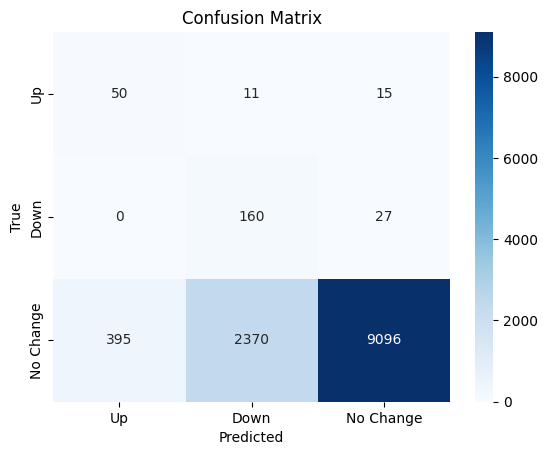

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Up", "Down", "No Change"],
            yticklabels=["Up", "Down", "No Change"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [20]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1, 2])
print(f"Up     -> P: {prec[0]:.2f}, R: {recall[0]:.2f}, F1: {f1[0]:.2f}")
print(f"Down   -> P: {prec[1]:.2f}, R: {recall[1]:.2f}, F1: {f1[1]:.2f}")
print(f"No Chg -> P: {prec[2]:.2f}, R: {recall[2]:.2f}, F1: {f1[2]:.2f}")


Up     -> P: 0.11, R: 0.66, F1: 0.19
Down   -> P: 0.06, R: 0.86, F1: 0.12
No Chg -> P: 1.00, R: 0.77, F1: 0.87


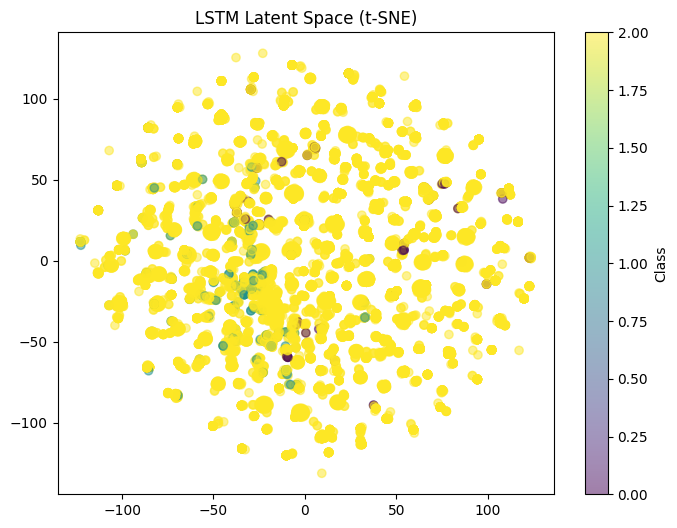

In [21]:
from sklearn.manifold import TSNE

embeddings = []
labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out, _ = model.lstm(xb)
        last_step = out[:, -1, :].cpu()
        embeddings.append(last_step)
        labels.append(yb)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="viridis", alpha=0.5)
plt.title("LSTM Latent Space (t-SNE)")
plt.colorbar(label="Class")
plt.show()


In [22]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 55.0 MB/s eta 0:00:00


In [23]:
model.eval()
dummy_input = torch.randn(1, sequence_length, feature_dim).to(device)
with torch.no_grad():
    torch.onnx.export(
        model,
        dummy_input,
        "quant_lstm.onnx",
        export_params=True,
        opset_version=11,
        input_names=["input"],
        output_names=["output"]
    )


/usr/local/lib/python3.11/dist-packages/brevitas/quant_tensor/int_quant_tensor.py:32: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  signed = torch.tensor(signed, dtype=torch.bool)
/usr/local/lib/python3.11/dist-packages/brevitas/quant_tensor/int_quant_tensor.py:34: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  training = torch.tensor(training, dtype=torch.bool)
/usr/local/lib/python3.11/dist-packages/brevitas/nn/mixin/base.py:185: TracerWarning: Converting a tensor to a Python 

In [24]:
from google.colab import files
files.download("quant_lstm.onnx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>